In [1]:
import cv2
import numpy as np
import requests
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
import datetime
from tensorflow import keras
from tensorflow.keras.models import Model
import tensorflow as tf
# Importation du jeu de données
import pathlib
import os

2024-05-15 22:21:05.460698: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#  On load le data set

In [9]:
data_dir = tf.keras.utils.get_file(
    "dataset.zip",
    "https://github.com/anisayari/Youtube-apprendre-le-deeplearning-avec-tensorflow/blob/master/%234%20-%20CNN/dataset.zip?raw=true",
    extract=False)

#import zipfile
#with zipfile.ZipFile(data_dir, 'r') as zip_ref:
    #zip_ref.extractall('/content/datasets')

data_dir = pathlib.Path('datasets/dataset')
print(data_dir)
print(os.path.abspath(data_dir))

datasets/dataset
/home/ssea2/Desktop/IA/vision_recoperso/Projet-IA/datasets/dataset


In [10]:
# Comptage du nombre d'images
image_count = len(list(data_dir.glob('*/*')))
print(image_count)

160


# On crée les 2 "axes" X=les images y=leurs labels

In [11]:
# Paramètres pour la création des ensembles de données
batch_size = 3
img_height = 200
img_width = 200

# Création des ensembles de données d'entraînement et de validation
train_data = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size,
)

val_data = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Noms de classe
class_names = val_data.class_names
print(class_names)

Found 157 files belonging to 1 classes.


Using 126 files for training.
Found 157 files belonging to 1 classes.
Using 31 files for validation.
['pikachu']


2024-05-15 22:21:08.157974: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


2024-05-15 22:44:53.192701: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [126]
	 [[{{node Placeholder/_4}}]]
2024-05-15 22:44:53.193014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [126]
	 [[{{node Placeholder/_0}}]]


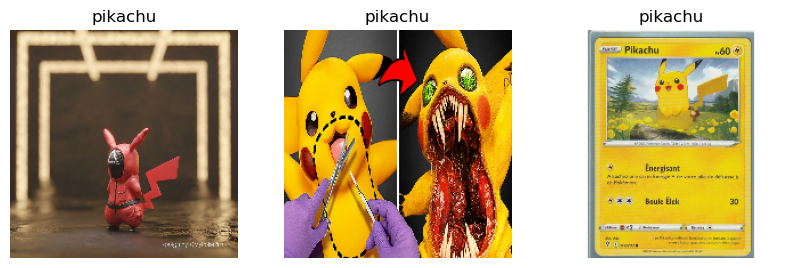

In [24]:

# Affichage des images d'exemple
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(3):
    ax = plt.subplot(1, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

 # initialisaton du model

In [13]:
layers=tf.keras.layers

# Définition du modèle CNN
num_classes = 2
model = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(128,4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16,4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

# Compilation du modèle
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'],)

In [14]:
# Callback pour TensorBoard
logdir="logs"
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir,histogram_freq=1, write_images=logdir,
                                                   embeddings_data=train_data)

On entraine le model sur les donnée train_data/val_data, se qui nous return l'acuracy du model

In [15]:

# Entraînement du modèle
model.fit( 
    train_data,
    validation_data=val_data,
    epochs=2,
    callbacks=[tensorboard_callback]
)

Epoch 1/2


2024-05-15 22:21:08.734071: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [126]
	 [[{{node Placeholder/_4}}]]
2024-05-15 22:21:08.734349: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [126]
	 [[{{node Placeholder/_4}}]]
/home/ssea2/anaconda3/envs/IA3-11-9/lib/python3.11/site-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logi

 4/42 [=>............................] - ETA: 12s - loss: 0.2377 - accuracy: 0.7500   

2024-05-15 22:21:11.470181: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/42 [===============>..............] - ETA: 6s - loss: 0.0413 - accuracy: 0.9565

2024-05-15 22:21:17.464294: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


42/42 [==============================] - ETA: 0s - loss: 0.0226 - accuracy: 0.9762

2024-05-15 22:21:23.106230: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [31]
	 [[{{node Placeholder/_4}}]]
2024-05-15 22:21:23.108635: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [31]
	 [[{{node Placeholder/_0}}]]


42/42 [==============================] - 16s 348ms/step - loss: 0.0226 - accuracy: 0.9762 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/2
 4/42 [=>............................] - ETA: 8s - loss: 0.0000e+00 - accuracy: 1.0000

2024-05-15 22:21:25.745809: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/42 [===============>..............] - ETA: 5s - loss: 0.0000e+00 - accuracy: 1.0000

2024-05-15 22:21:31.931997: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


42/42 [==============================] - 14s 342ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


In [18]:
"""
# Fonction pour afficher les filtres de convolution
def display_filter(model, layer_name):
    layer = model.get_layer(layer_name)
    filter, bias= layer.get_weights()
    dim = filter.shape[3]
    print(f'{layer_name} | Filter Shape: {filter.shape} Bias Shape: {bias.shape}')
    print(f'Dimension {dim}')
    f_min, f_max = filter.min(), filter.max()
    filter = (filter - f_min) / (f_max - f_min)
    print(filter.shape)
    fig= plt.figure(figsize=(30,30))
    for i in range(dim):
        ax = fig.add_subplot(dim/2,dim/2,i+1)
        ax.axis('off')
        try:
            ax.imshow(filter[:,:,:,i])
        except:
            ax.imshow(filter[:,:,:,i][0])

# Affichage des filtres de convolution
display_filter(model,f'conv2d_{num}')"""

"\n# Fonction pour afficher les filtres de convolution\ndef display_filter(model, layer_name):\n    layer = model.get_layer(layer_name)\n    filter, bias= layer.get_weights()\n    dim = filter.shape[3]\n    print(f'{layer_name} | Filter Shape: {filter.shape} Bias Shape: {bias.shape}')\n    print(f'Dimension {dim}')\n    f_min, f_max = filter.min(), filter.max()\n    filter = (filter - f_min) / (f_max - f_min)\n    print(filter.shape)\n    fig= plt.figure(figsize=(30,30))\n    for i in range(dim):\n        ax = fig.add_subplot(dim/2,dim/2,i+1)\n        ax.axis('off')\n        try:\n            ax.imshow(filter[:,:,:,i])\n        except:\n            ax.imshow(filter[:,:,:,i][0])\n\n# Affichage des filtres de convolution\ndisplay_filter(model,f'conv2d_{num}')"